# LDA
- Brigitte Hogan (bwh5v@virginia.edu) & Jason Tiezzi (jbt5am@virginia.edu)  
- DS 5001  
- April 2020  
---
Create a topic model from our corpus  using SciKit Learn's library.

# Setup

## Import

#### LDA

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer          # CountVectorizer creates document term matrix, doesn't do POS
from sklearn.decomposition import LatentDirichletAllocation as LDA
import os

In [2]:
%matplotlib inline

In [3]:
# For LDA Visualization
import plotly_express as px # comment & clear output below to return Jupyter Lab buttons
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

#### Clustering

In [4]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

## Configs

In [5]:
#data_dir = '../../Notebooks/Homework/Homework08_LDA/data/' # Homework example
data_dir = 'Tables/' # Cookbook

In [6]:
n_terms  = 5000 # trying more words, original was 4000
n_topics = 30  # tried fewer, didn't help
max_iter = 5

#OHCO = ['book_id', 'chap_num', 'para_num'] # homework example
OHCO_full = ['book_id', 'vol_num', 'chap_num', 'recp_num', 'para_num', 'sent_num', 'token_num'] # full cookbook OHCO
OHCO = ['book_id', 'recp_num', 'para_num'] # LDA Cookbook OHCO (drop volume & chapter)

## Define Functions

In [7]:
def plot_tree(PHI, GROUP, metric = 'euclidean', method = 'ward'):
    
    # Get variables
    SIMS = pdist(normalize(PHI), metric=metric)
    TREE = sch.linkage(SIMS, method=method)
    labels  = ["{}: {}".format(a,b) for a, b in zip(GROUP.index, GROUP.topterms.tolist())]
    
    # Plots dendrogram of topics
    plt.figure();
    fig, axes = plt.subplots(figsize=(5, 10));
    dendrogram = sch.dendrogram(TREE, labels=labels, orientation="left");
    plt.tick_params(axis='both', which='major', labelsize=14);

In [8]:
def getTopics(PHI, THETA):
    TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)
    TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x), 1) # add label column
    TOPICS['doc_weight_sum'] = THETA.sum()
    return TOPICS

In [86]:
def get_Authors(THETA, LIB, OHCO, TOPICS, n_topics = 30, author_name = 'author'):
    topic_cols = [t for t in range(n_topics)]
    AUTHORS = THETA.join(LIB, on='book_id')\
        .reset_index().set_index([author_name]+OHCO)\
        .groupby(author_name)[topic_cols].mean()\
        .T                                            
    AUTHORS.index.name = 'topic_id'
    AUTHORS['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)
    return AUTHORS

In [9]:
def get_Group(THETA, LIB, OHCO, TOPICS, n_topics = 30, name = 'author'):
    topic_cols = [t for t in range(n_topics)]
    GROUPS = THETA.join(LIB, on='book_id')\
        .reset_index().set_index([name]+OHCO)\
        .groupby(name)[topic_cols].mean()\
        .T                                            
    GROUPS.index.name = 'topic_id'
    GROUPS['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)
    return GROUPS

---
# Prepare Data

## Read in files

#### Create 'TOKEN2.csv' (optional; if not done in BOW/TFIDF)

In [10]:
if os.path.exists(data_dir + 'TOKEN2.csv') == False:
    #
    # read in tables
    TOKEN = pd.read_csv(data_dir + 'TOKEN.csv').set_index(OHCO_full)
    VOCAB = pd.read_csv(data_dir + 'VOCAB.csv')
    #
    # adjust TOKEN table to match VOCAB
    TOKEN = TOKEN[~TOKEN.term_str.isna()]
    #
    # Add term_id to TOKEN to cobmine VOCAB & TOKEN tables later
    TOKEN['term_id'] = TOKEN.term_str.map(VOCAB.reset_index().set_index('term_str').term_id) # using .map() because no shared index yet
    TOKEN.to_csv(data_dir + 'TOKEN2.csv')
    #
    print('Created TOKEN2.csv in' + data_dir)

In [11]:
TOKENS = pd.read_csv(data_dir + 'TOKEN2.csv') # Cookbooks

In [12]:
LIB = pd.read_csv(data_dir + 'LIB.csv').set_index('book_id')

## Convert TOKENs to Table of Paragraphs

Scikit Learn wants an F1 style corpus. We create onefrom our annotated TOKEN table, keeping only regular nouns.  
*going backwards now, reform strings*

In [13]:
TOKENS.head()

book_id  vol_num  chap_num  recp_num  para_num  sent_num  token_num  \
0     9935        1         1       1.0         0         0          0   
1     9935        1         1       1.0         0         1          0   
2     9935        1         1       1.0         0         1          1   
3     9935        1         1       1.0         0         1          3   
4     9935        1         1       1.0         0         1          4   

             pos_tuple  pos token_str  term_str  term_id  
0          ('1', 'CD')   CD         1         1       14  
1    ('Without', 'IN')   IN   Without   without    16577  
2      ('doubt', 'NN')   NN     doubt     doubt     5252  
3        ('the', 'DT')   DT       the       the    15108  
4  ('greatest', 'JJS')  JJS  greatest  greatest     7253

*taking nouns with a possible 's' at the end*

In [14]:
PARAS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'para_str'})

In [15]:
PARAS.head()

para_str
book_id recp_num para_num                                                   
9935    1.0      0         doubt problem race food order person life body...
        2.0      0         principles cooking food refers preparation foo...
        3.0      0         providing food home matter lot housewife fact ...
        4.0      0         factor problem food housewife distinction wast...
                 1         connection problem waste leakage household cau...

## Create Vector Space

We use Scikit Learn's CountVectorizer to convert our F1 corpus of paragraphs into a document-term vector space of word counts.

In [16]:
tfv = CountVectorizer(max_features=n_terms, stop_words='english')
tf = tfv.fit_transform(PARAS.para_str)
TERMS = tfv.get_feature_names()

---
# Generate Model

We run Scikit Learn's [LatentDirichletAllocation algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) and extract the THETA and PHI tables.

In [17]:
lda = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

## THETA

In [18]:
THETA = pd.DataFrame(lda.fit_transform(tf), index=PARAS.index)
THETA.columns.name = 'topic_id'

In [19]:
THETA.sample(20).style.background_gradient()

## PHI

*what Raf calls language models*  
*basically an expansion of the vocab table*  
*Phi/Theta are same size as DOC, so could bind them*  

In [20]:
PHI = pd.DataFrame(lda.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [21]:
PHI.T.head().style.background_gradient()

---
# Inspect Results

## Get Top Terms per Topic

In [22]:
TOPICS = getTopics(PHI, THETA)

In [23]:
TOPICS

term_str            0           1            2            3        4  \
topic_id                                                               
0               juice       sugar        water        fruit    lemon   
1              crumbs      butter        sauce       pepper  parsley   
2                cook        meat      flavour        sauce     time   
3             lettuce    dressing        salad       pieces   slices   
4                food        rice      cereals        wheat      use   
5            potatoes      coffee         meal       cheese     corn   
6               water     minutes        pound     pressure     pint   
7               water       sauce      boiling         time   salmon   
8               sugar        eggs         milk          egg    water   
9              method        fish         kind  preparation  methods   
10               meat         pan         beef        steak    roast   
11               head      pounds       weight       couple   pieces   
12                tsp        salt       butter     tomatoes    water   
13              crust         pie       butter        bread     time   
14               fish       water         dish         hour     salt   
15                ice       cream      mixture          egg    cakes   
16              salad     cooking       salads      poultry      fat   
17                fat        meat         beef         salt     pork   
18               food      fruits        foods   vegetables    fruit   
19              bread  sandwiches       slices         time   loaves   
20               milk       cream        water         pint    sugar   
21               oven        dish        layer        place     bone   
22              sauce         pan      chicken       butter  minutes   
23              cocoa       water       coffee    chocolate     corn   
24                cup    teaspoon  tablespoons         cups    water   
25             apples      dishes         dish       dinner   recipe   
26               jars        peas          jar   vegetables     food   
27        ingredients        cake        flour       liquid    dough   
28              water        salt       butter       pepper      pan   
29               soup        food        soups         fuel    foods   

term_str            5           6        7           8        9  \
topic_id                                                          
0              orange    gelatine    jelly   pineapple    syrup   
1                salt        pint      egg       bread    onion   
2                soup         day   palate      sauces  vinegar   
3                skin      leaves      oil       knife  vinegar   
4                 tea      family    value      grains   cereal   
5              flavor         way    cream     carrots     dish   
6         temperature      pounds    ounce         air     jars   
7                 tea        cook  minutes        salt   tender   
8              butter       flour  mixture        salt      tsp   
9              pastry   varieties    kinds    desserts      way   
10              chops       piece   steaks       gravy     dish   
11               meat        game    thyme      course     beef   
12              beans  vegetables   flavor      pepper     milk   
13               loaf       paste    place         ham  filling   
14              toast         cod    hours      butter      day   
15             cheese       place     eggs        salt    beans   
16        temperature         oil     year        meat     time   
17              water       flour   mutton        hare    bacon   
18              value     protein    sugar        body     form   
19               work       place   butter       slice     meat   
20            minutes        time    mould       place   butter   
21             slices      butter  minutes       flesh    piece   
22               salt        dish   pepper       water    flour   
23          beverage

## Sort Topics by Doc Weight

*this picks out different topics even though it doesn't know which author wrote which text*  
*can also find topics that cross-cut*

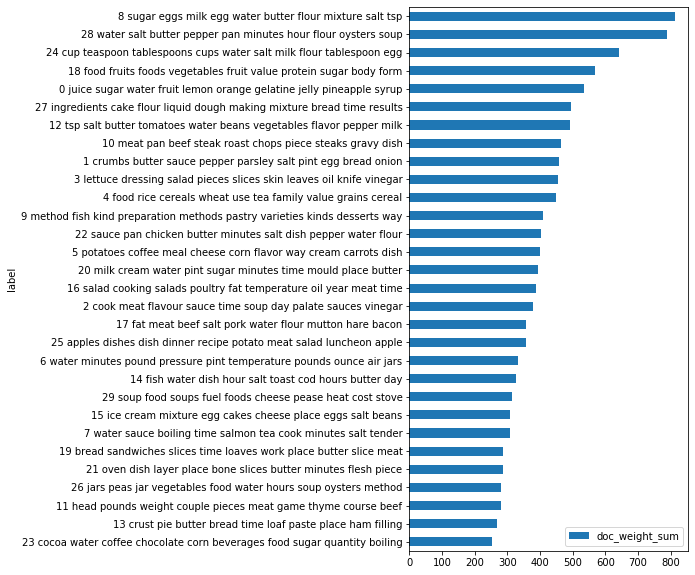

In [24]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10));

## LIB Table

In [25]:
LIB

author_last                                      author_full  \
book_id                                                                
9935          WIDAS  Woman's Institute of Domestic Arts and Sciences   
9936          WIDAS  Woman's Institute of Domestic Arts and Sciences   
9937          WIDAS  Woman's Institute of Domestic Arts and Sciences   
9938          WIDAS  Woman's Institute of Domestic Arts and Sciences   
9939          WIDAS  Woman's Institute of Domestic Arts and Sciences   
10582       Bradley                                    Alice Bradley   
12519       Randolf                                    Mary Randolph   
15464       Goudiss                                    Alice Bradley   
19077          Hill                              Janet McKenzie Hill   
24205        Murrey                                 Thomas J. Murrey   
24542        Murrey                                 Thomas J. Murrey   
25007        Murrey                                 Thomas J. Murrey   
28681     Kitchiner                                William Kitchiner   
29519        Hooper                                      Mary Hooper   
32472          Lusk                                      Graham Lusk   
34107     Santiagoe                                 Daniel Santiagoe   
38464        Murrey                                 Thomas J. Murrey   
53521        Murrey                                 Thomas J. Murrey   
54568        Boland                                   Mary A. Boland   
61185         Payne                                 Arthur Gay Payne   

         book_year                                      book_title  \
book_id                                                              
9935          1923    Woman's Institute Library of Cookery, Vol. 1   
9936          1923    Woman's Institute Library of Cookery, Vol. 2   
9937          1923    Woman's Institute Library of Cookery, Vol. 3   
9938          1923    Woman's Institute Library of Cookery, Vol. 4   
9939          1923    Woman's Institute Library of Cookery, Vol. 5   
10582         1923                  For Luncheon and Supper Guests   
12519         1860                          The Virginia Housewife   
15464         1918     Foods That Will Win The War And How To Cook   
19077         1909  Salads, Sandwiches and Chafing - Dish Dainties   
24205         1885                              Breakfast Dainties   
24542         1885                                    Fifty Salads   
25007         1884                                     Fifty Soups   
28681         1830     The Cook's Oracle; and Housekeeper's Manual   
29519         1892                          Nelson's Home Comforts   
32472         1918                                Food in War Time   
34107         1887                      The Curry Cook's Assistant   
38464         1891                           Tempting Curry Dishes   
53521         1888                                Oysters and Fish   
54568         1893                   A Handbook of Invalid Cooking   
61185         1877                Common - Sense Papers on Cookery   

                                             book_file  
book_id                                                 
9935            Cookbooks/WIDAS1923_WILCV01_pg9935.txt  
9936            Cookbooks/WIDAS1923_WILCV02_pg9936.txt  
9937            Cookbooks/WIDAS1923_WILCV03_pg9937.txt  
9938            Cookbooks/WIDAS1923_WILCV04_pg9938.txt  
9939            Cookbooks/WIDAS1923_WILCV05_pg9939.txt  
10582           Cookbooks/Bradley1923_FLSG_pg10582.txt  
12519    Cookbooks/Randolf1860_VAHousewife_pg12519.txt  
15464            Cookbooks/Goudiss1918_War_pg15464.txt  
19077             Cookbooks/Hill1909_SSCDD_pg19077.txt  
24205           Cookbooks/Murrey1885_Bfast_pg24205.txt  
24542          Cookbooks/Murrey1885_Salads_pg24542.txt  
25007           Cookbooks/Murrey1884_Soups_pg25007.txt  
28681          Cookbooks/Kitchiner1830_TCO_pg28681.txt  
29519             Cookbooks

### Adding time period

In [26]:
# adding in a feature for the rough period of time
per = []
for i in range(0, len(LIB)):
    # creating three groups -- those after 1900, those in the late 1800s, and those in the mid 1800s
    # creating three groups -- those after 1920, those in the late 1800s, and those in the mid 1800s
    if LIB.book_year.iloc[i] >= 1900: 
        value = '1900s'
    elif LIB.book_year.iloc[i] >= 1875:
        value = "late-1800s"
    else:
        value = "mid-1800s"
    per.append(value)
LIB['period'] = per

In [40]:
# adding in a feature for the rough period of time
dec = []
for i in range(0, len(LIB)):
    # creating three groups -- those after 1920, those in the late 1800s, and those in the mid 1800s
    if LIB.book_year.iloc[i] >= 1920: 
        value = '1920s'
    elif LIB.book_year.iloc[i] >= 1910:
        value = "1910s"
    elif LIB.book_year.iloc[i] >= 1900:
        value = "1900s"
    elif LIB.book_year.iloc[i] >= 1890:
        value = "1890s"
    elif LIB.book_year.iloc[i] >= 1880:
        value = "1880s"  
    else:
        value = "pre-1880s"
    dec.append(value)
LIB['decade'] = dec

In [41]:
LIB.sort_values(['book_year'])

author_last                                      author_full  \
book_id                                                                
28681     Kitchiner                                William Kitchiner   
12519       Randolf                                    Mary Randolph   
61185         Payne                                 Arthur Gay Payne   
25007        Murrey                                 Thomas J. Murrey   
24542        Murrey                                 Thomas J. Murrey   
24205        Murrey                                 Thomas J. Murrey   
34107     Santiagoe                                 Daniel Santiagoe   
53521        Murrey                                 Thomas J. Murrey   
38464        Murrey                                 Thomas J. Murrey   
29519        Hooper                                      Mary Hooper   
54568        Boland                                   Mary A. Boland   
19077          Hill                              Janet McKenzie Hill   
15464       Goudiss                                    Alice Bradley   
32472          Lusk                                      Graham Lusk   
9939          WIDAS  Woman's Institute of Domestic Arts and Sciences   
9938          WIDAS  Woman's Institute of Domestic Arts and Sciences   
9937          WIDAS  Woman's Institute of Domestic Arts and Sciences   
9936          WIDAS  Woman's Institute of Domestic Arts and Sciences   
10582       Bradley                                    Alice Bradley   
9935          WIDAS  Woman's Institute of Domestic Arts and Sciences   

         book_year                                      book_title  \
book_id                                                              
28681         1830     The Cook's Oracle; and Housekeeper's Manual   
12519         1860                          The Virginia Housewife   
61185         1877                Common - Sense Papers on Cookery   
25007         1884                                     Fifty Soups   
24542         1885                                    Fifty Salads   
24205         1885                              Breakfast Dainties   
34107         1887                      The Curry Cook's Assistant   
53521         1888                                Oysters and Fish   
38464         1891                           Tempting Curry Dishes   
29519         1892                          Nelson's Home Comforts   
54568         1893                   A Handbook of Invalid Cooking   
19077         1909  Salads, Sandwiches and Chafing - Dish Dainties   
15464         1918     Foods That Will Win The War And How To Cook   
32472         1918                                Food in War Time   
9939          1923    Woman's Institute Library of Cookery, Vol. 5   
9938          1923    Woman's Institute Library of Cookery, Vol. 4   
9937          1923    Woman's Institute Library of Cookery, Vol. 3   
9936          1923    Woman's Institute Library of Cookery, Vol. 2   
10582         1923                  For Luncheon and Supper Guests   
9935          1923    Woman's Institute Library of Cookery, Vol. 1   

                                             book_file      period     decade  
book_id                                                                        
28681          Cookbooks/Kitchiner1830_TCO_pg28681.txt   mid-1800s  pre-1880s  
12519    Cookbooks/Randolf1860_VAHousewife_pg12519.txt   mid-1800s  pre-1880s  
61185             Cookbooks/Payne1877_CSPC_pg61185.txt  late-1800s  pre-1880s  
25007           Cookbooks/Murrey1884_Soups_pg25007.txt  late-1800s      1880s  
24542          Cookbooks/Murrey1885_Salads_pg24542.txt  late-1800s      1880s  
24205           Cookbooks/Murrey1885_Bfast_pg24205.txt  late-1800s      1880s  
34107        Cookbooks/Santiagoe1887_Curry_pg34107.txt  late-1800s      1880s  
53521            Cookbooks/Murrey1888_Fish_pg53521.txt  late-1800s      1880s  
38464           Cookbooks/Murrey1891_Curry_pg38464.txt  late-1800s      1890s  
29

## Explore Topics by Author

*see which topics correlate strongly with which author*

In [29]:
AUTHORS = get_Group(THETA, LIB, OHCO, TOPICS, name='author_last')

In [30]:
AUTHORS.sort_values('WIDAS', ascending=False).style.background_gradient()

## Plotly

* Q: how to correct if data is imbalanced?
* A: standardize bag; some only use paragraphs, others use evenly-sized chunks

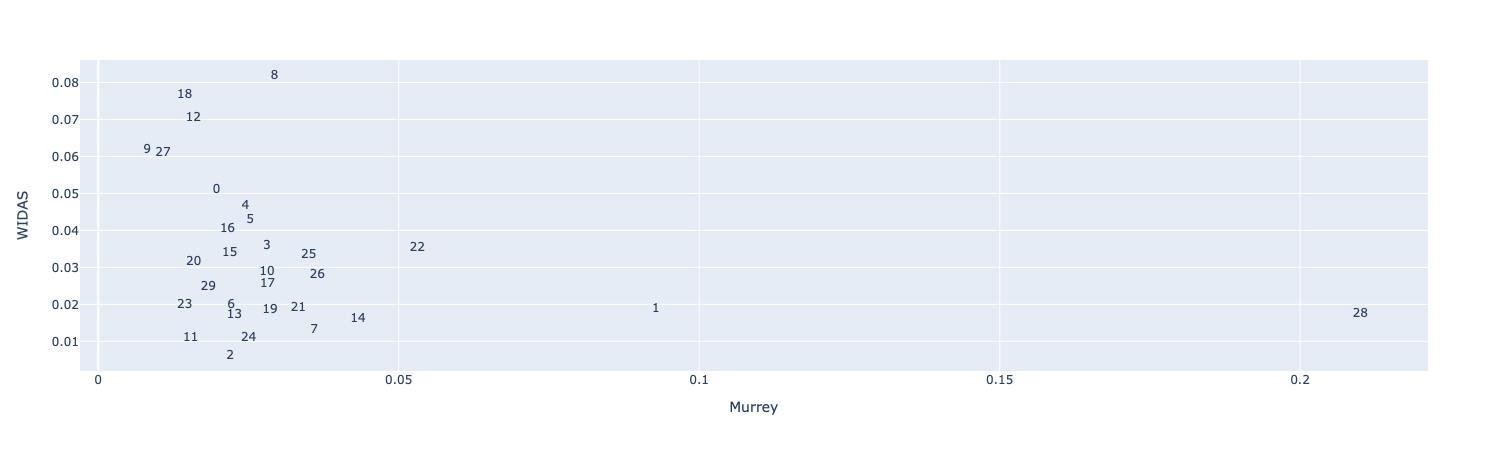

In [31]:
px.scatter(AUTHORS.reset_index(), 'Murrey', 'WIDAS', hover_name='topterms', text='topic_id')\
    .update_traces(mode='text')

---
## Explore Topics by Period

In [32]:
PERIOD = get_Group(THETA, LIB, OHCO, TOPICS, name='period')

In [33]:
PERIOD.sort_values('mid-1800s', ascending=False).style.background_gradient()

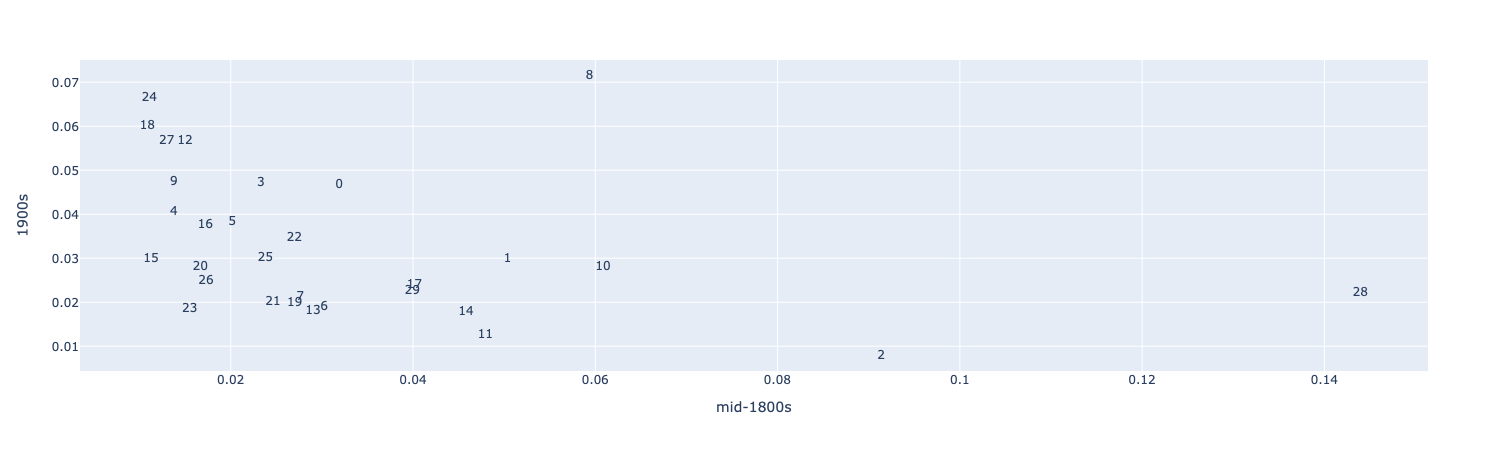

In [34]:
px.scatter(PERIOD.reset_index(), 'mid-1800s', '1900s', hover_name='topterms', text='topic_id')\
    .update_traces(mode='text')

---
## Explore Topics by Decade

In [42]:
DECADE = get_Group(THETA, LIB, OHCO, TOPICS, name='decade')

In [43]:
DECADE.sort_values('1920s', ascending=False).style.background_gradient()

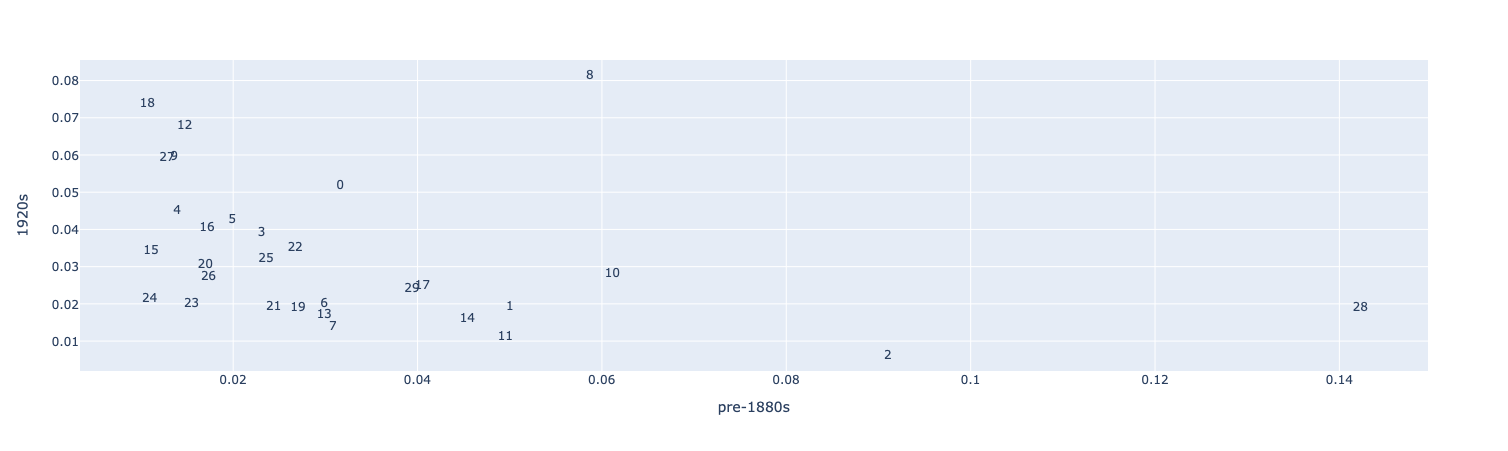

In [44]:
px.scatter(DECADE.reset_index(), 'pre-1880s', '1920s', hover_name='topterms', text='topic_id')\
    .update_traces(mode='text')

---
# Cluster Topics

*some of the topics that cluster closely might be the same*  
*can use this method to come up with more coherent topics*

<Figure size 432x288 with 0 Axes>

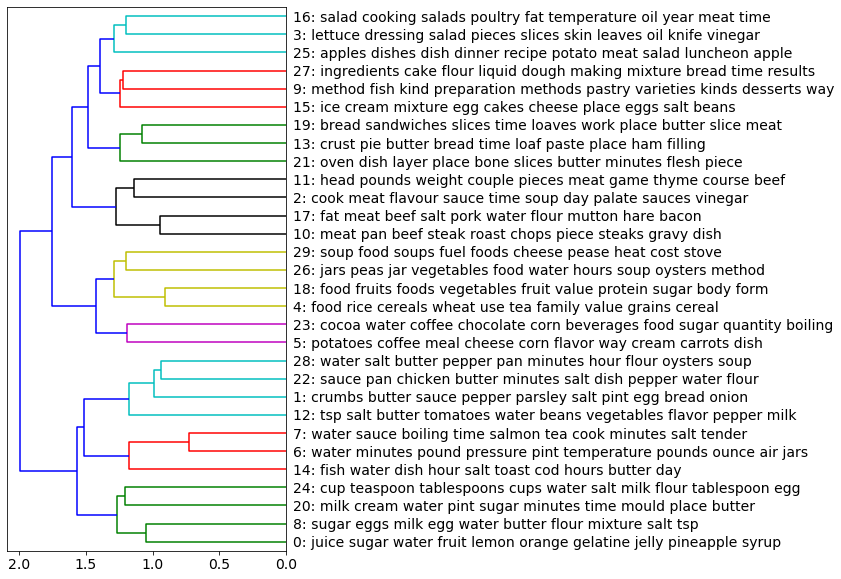

In [35]:
plot_tree(PHI, AUTHORS)

<Figure size 432x288 with 0 Axes>

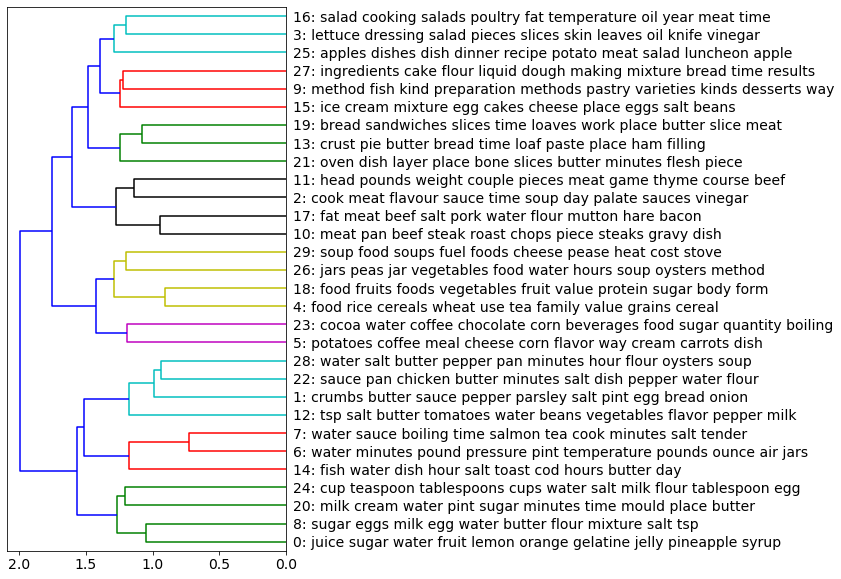

In [36]:
plot_tree(PHI, PERIOD)

<Figure size 432x288 with 0 Axes>

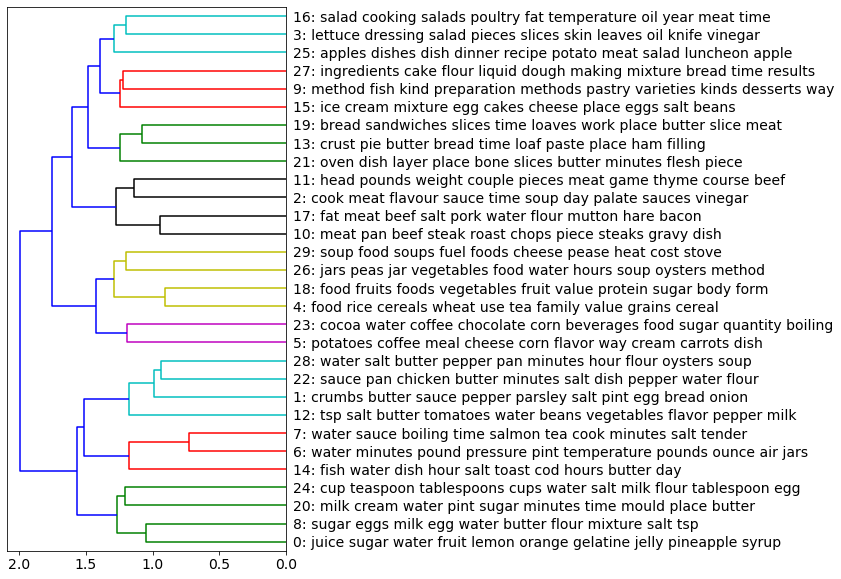

In [45]:
plot_tree(PHI, DECADE)

---
# LDA Viz


*Raf hasn't looked into relevance metric*  
*syndrome = common set of things*  
*Sid: common problem is you get different visual every time, even if you try to set seed*  
*Raf: this is something of a black box, not well-documented, doesn't have explanation*  
*Sid: if you evaluate LDA with coherence measure, can you use this to get number of topics to specify in model; but still doesn't feel he knows how to specify exactly*  
*Raf: I don't know how to select number either; you can define a threshold of similarity*

In [37]:
pyLDAvis.sklearn.prepare(lda, tf, tfv)

/Users/Kobresia/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
28     0.257345  0.057324       1        1  8.056090
8      0.182446 -0.214725       2        1  6.922037
18    -0.259242 -0.083426       3        1  4.893348
24     0.224957 -0.193963       4        1  4.412778
7      0.098215  0.063366       5        1  3.975603
27    -0.100967 -0.136946       6        1  3.918492
4     -0.254245 -0.019902       7        1  3.862732
0      0.021185 -0.167146       8        1  3.822379
10     0.056313  0.177414       9        1  3.580805
3      0.135650  0.003954      10        1  3.563057
1      0.233271  0.007502      11        1  3.471471
2     -0.011625  0.179550      12        1  3.358897
20     0.020368 -0.141625      13        1  3.268506
12     0.040859 -0.019712      14        1  3.225288
17     0.058109  0.119241      15        1  3.190635
9     -0.218641 -0.098834      16        1  3.015642
22     0.159220 -0.012332      17        1  2.959899
6      0.013704 -0.040643      18        1  2.761458
16    -0.177832  0.038906      19        1  2.717319
14     0.090154  0.112810      20        1  2.553790
15     0.019971 -0.134893      21        1  2.525790
11     0.018940  0.188439      22        1  2.510454
5     -0.115149 -0.051959      23        1  2.401213
13    -0.043565  0.099130      24        1  2.371579
29    -0.180379  0.080976      25        1  2.240047
25    -0.138607  0.039097      26        1  2.238995
19    -0.069395  0.106584      27        1  2.207449
21     0.135161  0.074969      28        1  2.145421
26    -0.088060  0.012659      29        1  2.022500
23    -0.108162 -0.045815      30        1  1.806326, topic_info=     Category         Freq       Term        Total  loglift  logprob
2766  Default  2497.000000       milk  2497.000000  30.0000  30.0000
1145  Default  1245.000000        cup  1245.000000  29.0000  29.0000
4427  Default  2298.000000      sugar  2298.000000  28.0000  28.0000
4868  Default  4632.000000      water  4632.000000  27.0000  27.0000
466   Default  1216.000000      bread  1216.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
2687  Topic30    17.533149  materials   199.621134   1.5815  -5.4190
20    Topic30    17.670377       acid   237.130706   1.4172  -5.4112
2025  Topic30    17.475008     grains   222.020022   1.4719  -5.4224
4616  Topic30    18.994286       time  1490.859971  -0.3491  -5.3390
4758  Topic30    17.543753      value   485.810796   0.6928  -5.4184

[2124 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
6        12  0.722950     acceptation
11       12  0.666423  accompaniments
11       14  0.025632  accompaniments
11       16  0.179422  accompaniments
11       27  0.102527  accompaniments
...     ...       ...             ...
4992     13  0.003734           yolks
4992     17  0.070941           yolks
4993     22  0.744713       yorkshire
4993     25  0.124119       yorkshire
4996      6  0.864502              yr

[9375 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[29, 9, 19, 25, 8, 28, 5, 1, 11, 4, 2, 3, 21, 13, 18, 10, 23, 7, 17, 15, 16, 12, 6, 14, 30, 26, 20, 22, 27, 24])